# Predicting Car Accidents in Denver County
<hr>

In [ ]:
# Step 1 Import libraries

# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid
from IPython.display import HTML, display

%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [ ]:
# Step 2: Import the data set

#df = pd.read_csv('Data/US_Accidents_Dec19.csv')
#df.info()

In [ ]:
# # Step 3. Extract year, month, day, hour, weekday, and time to clear accidents

# # Convert Start_Time and End_Time to datetypes
# df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
# df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# # Extract year, month, day, hour and weekday
# df['Year']=df['Start_Time'].dt.year
# df['Month']=df['Start_Time'].dt.strftime('%b')
# df['Day']=df['Start_Time'].dt.day
# df['Hour']=df['Start_Time'].dt.hour
# df['Weekday']=df['Start_Time'].dt.strftime('%a')

# # Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
# td='Time_Duration(min)'
# df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
# #df.info()

In [ ]:
# # Step 4. Deal with outliers
# # A. Drop rows with negative time_duration

# # Drop the rows with td<0
# neg_outliers=df[td]<=0

# # Set outliers to NAN
# df[neg_outliers] = np.nan

# # Drop rows with negative td
# df.dropna(subset=[td],axis=0,inplace=True)
# #df.info()

In [ ]:
# # Double check to make sure no more negative td
# df[td][df[td]<=0]

In [ ]:
# # Step 4. Deal with outliers
# # B. Fill outliers with median values

# # Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

# n=3

# median = df[td].median()
# std = df[td].std()
# outliers = (df[td] - median).abs() > std*n

# # Set outliers to NAN
# df[outliers] = np.nan

# # Fill NAN with median
# df[td].fillna(median, inplace=True)

# df.info()

In [ ]:
# Export the cleaned data
# df.to_csv('Data/US_Accidents_Dec19_clean.csv',index=False)

In [ ]:
# Step 5. Select a list of features for machine learning algorithms
# Only select relavant columns without overwhelming the computer

# Set the list of features to include in Machine Learning
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat',
             'Distance(mi)','Side','City','County','State','Timezone',
             'Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)',
             'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing',
             'Give_Way','Junction','No_Exit','Railway','Roundabout','Station',
             'Stop','Traffic_Calming','Traffic_Signal','Turning_Loop',
             'Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']

In [ ]:
# # Select the dataset to include only the selected features
# df_sel=df[feature_lst].copy()
# #df_sel.info()

In [ ]:
# Export the data with selected features
# df_sel.to_csv('Data/US_Accidents_Dec19_clean_sel.csv',index=False)

In [ ]:
# Step 6. Drop rows with missing values
# Check missing values
#df_sel.isnull().mean()

# df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
#df_sel.shape

In [ ]:
# Doublecheck missing values have been removed
#df_sel.isnull().mean()

In [148]:
# Export the data with selected features
# df_sel.to_csv('Data/US_Accidents_Dec19_clean_sel_dropna.csv',index=False)

# Step 7. Select the state of interest: Colorado / County of interest: Denver

# Import data already exported based on previous work
df_sel=pd.read_csv('https://media.githubusercontent.com/media/jon-0/traffic-data/master/US_Accidents_Dec19_clean_sel_dropna.csv?token=AFSNJELAFS2VZKASKQPWBC26QFKAM')
df_sel.head()

,Source,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Side,City,County,State,Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Hour,Weekday,Time_Duration(min)
0,MapQuest,201.0,3.0,-84.058723,39.865147,0.01,R,Dayton,Montgomery,OH,US/Eastern,36.9,91.0,29.68,10.0,Calm,Light Rain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Night,5.0,Mon,314.0
1,MapQuest,201.0,2.0,-82.831184,39.928059,0.01,L,Reynoldsburg,Franklin,OH,US/Eastern,37.9,100.0,29.65,10.0,Calm,Light Rain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Night,6.0,Mon,30.0
2,MapQuest,201.0,2.0,-84.032608,39.063148,0.01,R,Williamsburg,Clermont,OH,US/Eastern,36.0,100.0,29.67,10.0,SW,Overcast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Night,6.0,Mon,30.0
3,MapQuest,201.0,3.0,-84.205582,39.747753,0.01,R,Dayton,Montgomery,OH,US/Eastern,35.1,96.0,29.64,9.0,SW,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Night,7.0,Mon,30.0
4,MapQuest,201.0,2.0,-84.188354,39.627781,0.01,R,Dayton,Montgomery,OH,US/Eastern,36.0,89.0,29.65,6.0,SW,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Day,7.0,Mon,30.0


In [149]:
# Set state
state='CO'

# Select the state of Colorado
df_state=df_sel.loc[df_sel.State==state].copy()
df_state.drop('State',axis=1, inplace=True)
#df_state.info()

## Visualizing Accidents in Colorado


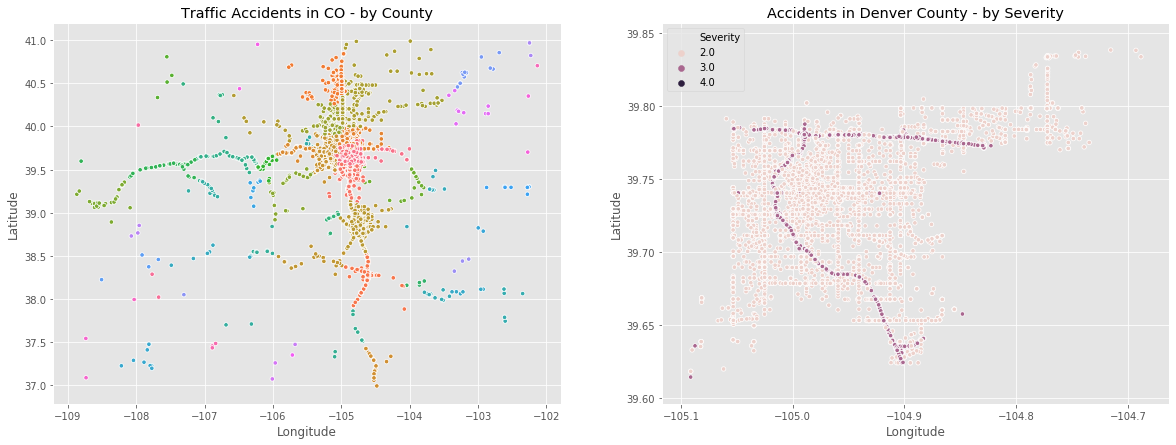

In [150]:
fig, (ax_map1, ax_map2) = plt.subplots(1, 2, figsize=(20,7))

# Map of accidents, color code by county
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20, ax=ax_map1)
ax_map1.set_title('Traffic Accidents in CO - by County')
ax_map1.set_ylabel('Latitude')
ax_map1.set_xlabel('Longitude')


# Set county
county='Denver'

# Select the state of Colorado
df_county=df_state.loc[df_state.County==county].copy()
df_county.drop('County',axis=1, inplace=True)


# Map of accidents, color code by Severity
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_county, hue='Severity', legend='full', s=20, ax=ax_map2)
ax_map2.set_title('Accidents in Denver County - by Severity')
ax_map2.set_ylabel('Latitude')
ax_map2.set_xlabel('Longitude')

text = plt.text



In [151]:
# Step 8. Deal with categorical data: pd.get_dummies()

# Generate dummies for categorical data
df_county_dummy = pd.get_dummies(df_county,drop_first=True)

# Export data
#df_county_dummy.to_csv('Data/US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

#df_county_dummy.info()

In [152]:
# Step 9. Predict the accident severity with various supervised machine learning algorithms
# Data preparation: train_test_split

# Assign the data
df=df_county_dummy

# Set the target for the prediction
target='Severity'


# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [153]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

In [ ]:
# Algorithm A. Logistic regression    

lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

# print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

In [ ]:
# Algorithm B. The K-Nearest Neighbors (KNN) algorithm
# KNN with 6 neighors

# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

# print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
# print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

In [ ]:
# Algorithm B. The K-Nearest Neighbors (KNN) algorithm
# Optmize the number of neighors: plot the accuracy versus number of neighbors


# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
# plt.title('k-NN: Varying Number of Neighbors')
# plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
# plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
# plt.legend()
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Accuracy')
#plt.show()


In [ ]:
# Algorithm C. Decision Tree

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
# print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
# print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

In [69]:
# Algorithm D. Random Forest
# n_estimators=100

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

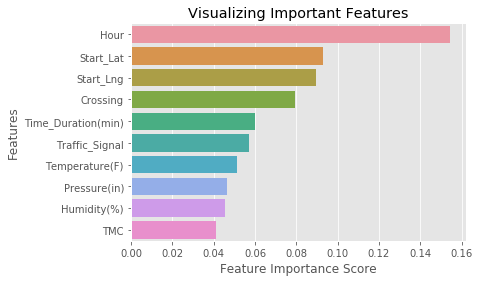

In [68]:
# Algorithm D. Random Forest
# Visualize important features
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [70]:
# Algorithm D. Random Forest
# Select the top important features, set the threshold

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
#for feature_list_index in sfm.get_support(indices=True):
#    print(feat_labels[feature_list_index])

In [73]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.

X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [74]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
#print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
#print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

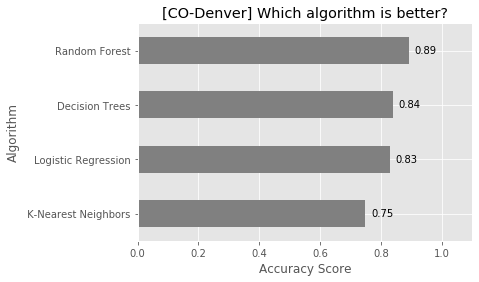

In [53]:
# Plot the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
# df_acc.to_csv('Data/Accuracy_scores_algorithms_{}.csv'.format(state),index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.1)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('[{}-{}] Which algorithm is better?'.format(state, county))

plt.show()

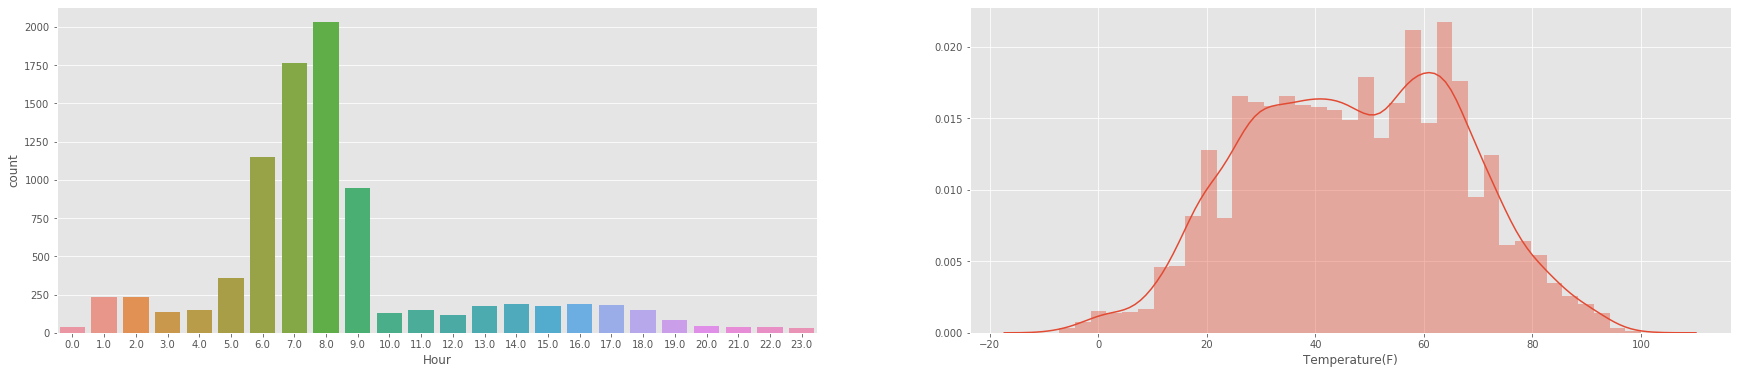

In [47]:
temperature = df['Temperature(F)']
hours = df["Hour"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,6))
sns.countplot(hours, ax=ax1)
sns.distplot(temperature, ax=ax2)

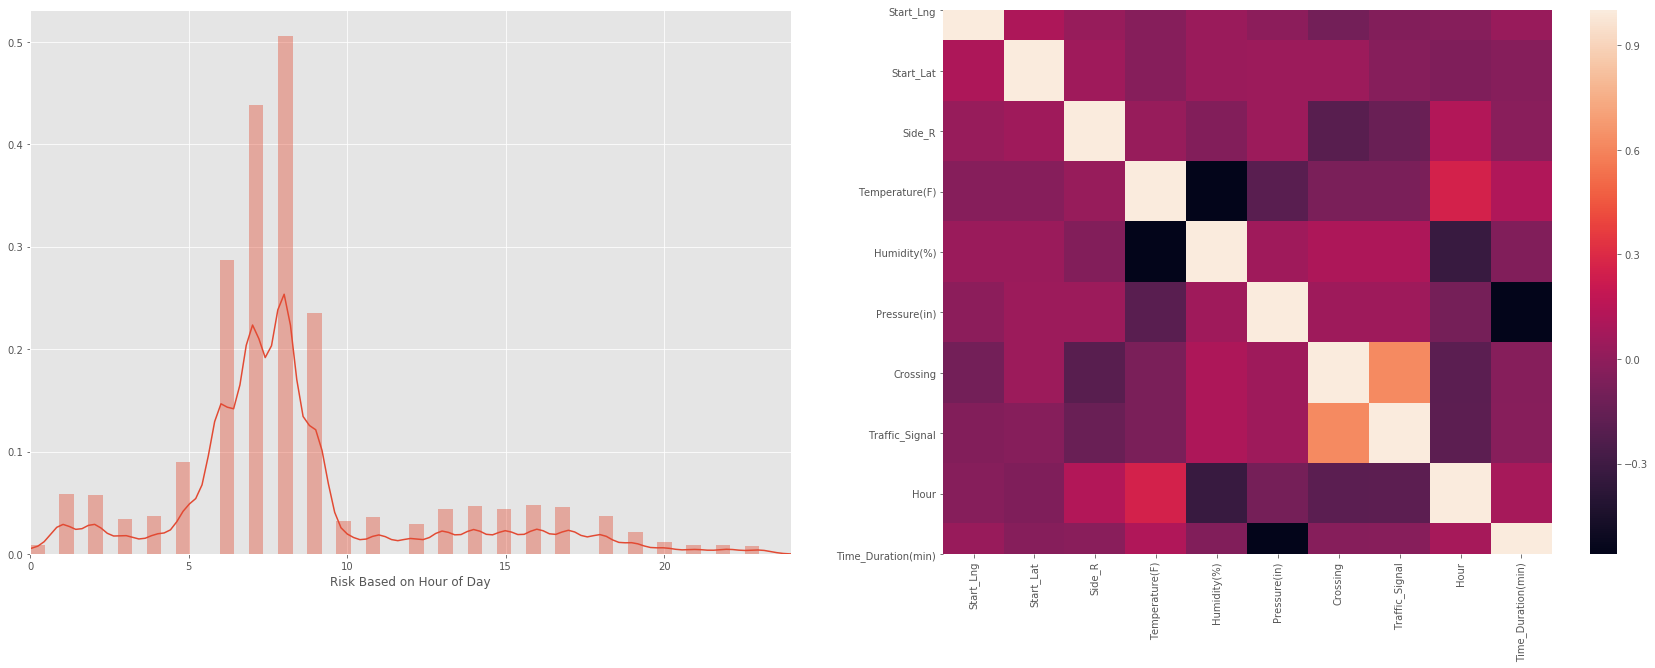

In [136]:
# Set the list of features to include for Correlation Matrix
feature_lst=['Start_Lng','Start_Lat',
             'Side_R', 'Temperature(F)','Humidity(%)','Pressure(in)', 
             'Crossing', 'Traffic_Signal','Hour', 'Time_Duration(min)']

# Select the dataset to include only the selected features
df_sel = df[feature_lst].copy()
dfgrid = df_sel.copy()

# prepare subplots
fig, (ax3,ax4) = plt.subplots(1,2, figsize=(30,10))

# Hour of Day is a key feature in predicting traffic accidents
sns.distplot(dfgrid['Hour'], ax=ax3, axlabel="Risk Based on Hour of Day").set_xlim(0,24)

#correlation matrix
corrmat = dfgrid.corr()
ax4 = sns.heatmap(corrmat)


In [145]:
HTML('''
<style type="text/css">

#wrap {
   width:600px;
   margin:50;
}
#left_col {
   float:left;
   width:350px;
}
#right_col {
   float:right;
   width:250px;
}
</style>
<div id="wrap">
    <div id="left_col">
<p><h3>Data Frame</h3><p>
Run interactive queries in the data frame below.
<ul>
<li>Click the column to resort the dataframe by value.</li>
<li>Click the filter and set a range to filter by range.</li>
<li>Move both sliders to the same position to filter by that value. 
For example, to see all accidents with rear side collision, move the slider in the Side_R filter to 1.</li>
<li>Click reset to remove your filters. </ul></div></li>

<div id="right_col">
<ul>Start Longitude<br>
Start Latitude<br>
Side_R = Rear Side Collision (binary)<br>
Temperature<br>
Humidity %<br>
Pressure (in)<br>
Crossing (binary)<br>
Traffic Signal (binary)<br>
Hour (of Day)<br>
Time Duration in Minutes<br></ul></div>''')

In [146]:
df_widget = qgrid.show_grid(dfgrid, grid_options={
    # SlickGrid options
    'fullWidthRows': False,
    'syncColumnCellResize': False,
    'forceFitColumns': True,
    'defaultColumnWidth': 200,
    'rowHeight': 25,
    'enableColumnReorder': False,
    'enableTextSelectionOnCells': True,
    'editable': False,
    'autoEdit': False,
    'explicitInitialization': True,

    # Qgrid options
    'maxVisibleRows': 20,
    'minVisibleRows': 8,
    'sortable': True,
    'filterable': True,
    'highlightSelectedCell': False,
    'highlightSelectedRow': True},
    
    column_options={
    # SlickGrid column options
    'defaultSortAsc': True,
    'maxWidth': 300,
    'minWidth': 50,
    'resizable': True,
    'sortable': True,
    'toolTip': "",
    'width': None
})
df_widget.layout.width = "1000px"
df_widget.layout.height = "300px"
df_widget

QgridWidget(grid_options={'fullWidthRows': False, 'syncColumnCellResize': False, 'forceFitColumns': True, 'def…